<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-fundamentals/unit04-multilayer-networks/exercise_2_fashion-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing a Multilayer Perceptron (Fashion-MNIST)

## 1) Setup

In [ ]:
!wget https://github.com/rahiakela/deep-learning-research-and-practice/raw/main/deep-learning-fundamentals/unit04-multilayer-networks/helper_plotting.py

In [2]:
import os
import gzip
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import torch.nn.functional as F

from helper_plotting import plot_training_loss
from helper_plotting import plot_accuracy

In [ ]:
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz

!mkdir data
!mv *.gz data/

## 2) Loading the dataset

- Fashion-MNIST website: https://github.com/zalandoresearch/fashion-mnist

In [4]:
def load_mnist(path, kind='train'):

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [5]:
x_train_dataset, y_train_dataset = load_mnist("data", kind="train")
x_test_dataset, y_test_dataset = load_mnist("data", kind="t10k")

In [6]:
len(x_train_dataset), len(y_train_dataset)

(60000, 60000)

In [7]:
len(x_test_dataset)

10000

In [8]:
class MyDataset(Dataset):
    def __init__(self, features, labels, transform=None):

        self.transform = transform

        self.features = features
        self.labels = labels

    def __getitem__(self, index):
        img = self.features[index]
        img = torch.tensor(img).to(torch.float32)
        img = img/255.

        if self.transform is not None:
            img = self.transform(img)

        label = self.labels[index]

        return img, label

    def __len__(self):
        return self.labels.shape[0]

In [9]:
data_transforms = {
  "train": transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))  # normalize images to [-1, 1] range
  ]),
  "test": transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))  # normalize images to [-1, 1] range
  ]),
}

In [20]:
train_dataset = MyDataset(
  features=x_train_dataset,
  labels=y_train_dataset,
)

test_dataset = MyDataset(
  features=x_test_dataset,
  labels=y_test_dataset,
)

In [21]:
len(train_dataset)

60000

In [22]:
len(test_dataset)

10000

### Create a validation set

In [23]:
torch.manual_seed(1)
train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])

In [24]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

###Testing the data loaders

In [25]:
import time

num_epochs = 1
for epoch in range(num_epochs):
  for batch_idx, (x, y) in enumerate(train_loader):
      time.sleep(1)
      if batch_idx >= 3:
          break
      print(" Batch index:", batch_idx, end="")
      print(" | Batch size:", y.shape[0], end="")
      print(" | x shape:", x.shape, end="")
      print(" | y shape:", y.shape)

print("Labels from current batch:", y)

 Batch index: 0 | Batch size: 64 | x shape: torch.Size([64, 784]) | y shape: torch.Size([64])
 Batch index: 1 | Batch size: 64 | x shape: torch.Size([64, 784]) | y shape: torch.Size([64])
 Batch index: 2 | Batch size: 64 | x shape: torch.Size([64, 784]) | y shape: torch.Size([64])
Labels from current batch: tensor([4, 8, 9, 9, 9, 0, 6, 4, 7, 6, 0, 1, 7, 7, 7, 1, 3, 9, 7, 8, 8, 6, 9, 1,
        3, 8, 2, 2, 6, 6, 1, 3, 0, 4, 0, 7, 6, 4, 8, 2, 1, 3, 0, 5, 4, 8, 1, 1,
        2, 7, 7, 0, 5, 3, 9, 4, 2, 2, 3, 3, 5, 2, 1, 9], dtype=torch.uint8)


## 3) Implementing the model

In [26]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

## 4) The training loop

In [27]:
def compute_accuracy(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [28]:
torch.manual_seed(1)

model = PyTorchMLP(num_features=784, num_classes=10)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 30

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

Epoch: 001/030 | Batch 000/860 | Train Loss: 2.29
Epoch: 001/030 | Batch 250/860 | Train Loss: 1.90
Epoch: 001/030 | Batch 500/860 | Train Loss: 1.26
Epoch: 001/030 | Batch 750/860 | Train Loss: 0.83
Train Acc 68.13% | Val Acc 68.92%
Epoch: 002/030 | Batch 000/860 | Train Loss: 0.90
Epoch: 002/030 | Batch 250/860 | Train Loss: 0.93
Epoch: 002/030 | Batch 500/860 | Train Loss: 0.77
Epoch: 002/030 | Batch 750/860 | Train Loss: 0.75
Train Acc 76.77% | Val Acc 76.88%
Epoch: 003/030 | Batch 000/860 | Train Loss: 0.91
Epoch: 003/030 | Batch 250/860 | Train Loss: 0.62
Epoch: 003/030 | Batch 500/860 | Train Loss: 0.58
Epoch: 003/030 | Batch 750/860 | Train Loss: 0.43
Train Acc 79.60% | Val Acc 80.12%
Epoch: 004/030 | Batch 000/860 | Train Loss: 0.68
Epoch: 004/030 | Batch 250/860 | Train Loss: 0.61
Epoch: 004/030 | Batch 500/860 | Train Loss: 0.39
Epoch: 004/030 | Batch 750/860 | Train Loss: 0.69
Train Acc 80.65% | Val Acc 80.94%
Epoch: 005/030 | Batch 000/860 | Train Loss: 0.68
Epoch: 005/030

## 5) Evaluating the results

In [29]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Acc {train_acc*100:.2f}%")
print(f"Val Acc {val_acc*100:.2f}%")
print(f"Test Acc {test_acc*100:.2f}%")

Train Acc 87.72%
Val Acc 86.38%
Test Acc 85.62%


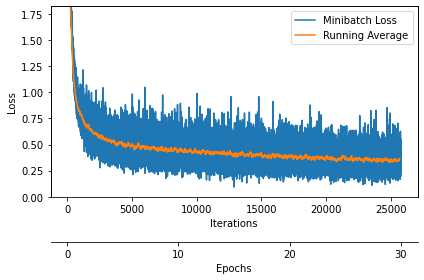

In [30]:
plot_training_loss(minibatch_loss_list=loss_list,
                   num_epochs=num_epochs,
                   iter_per_epoch=len(loss_list)//num_epochs)

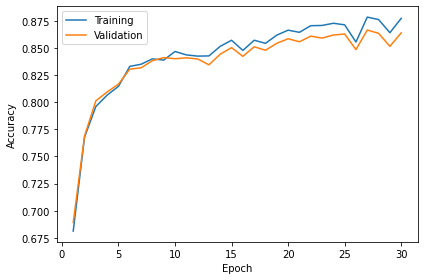

In [31]:
plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=val_acc_list)